# Tutorial 5: Quality Control for Time Resolved, Temperature-Jump SAXS Data Analysis

**Package Information:**<br>
Currently the [tr_tjump_saxs](https://github.com/ScientistAsh/tr_tjump_saxs/ "tr_tjump_saxs package") package only works through the Python3 command line. The full dependencies can be found on the [GitHub Page](https://github.com/ScientistAsh/tr_tjump_saxs/issues "tr_tjump_saxs") and the environment can be cloned from the [environment.yml file](https://github.com/ScientistAsh/tr_tjump_saxs/blob/main/environment.yml). The data analysis can be executed from an interactive Python command line such as [iPython](https://www.python.org/) or [Jupyter](https://jupyter.org/) or the code can be written in a script to run in a non-interactive mode. The preferred usage is in Jupyter Lab as this is the environment the package was developed in. Jupyter also provides a file where all code and output of code and notes can be contained in a single file and serves a record of the data analysis performed, the code used to conduct the data analysis, and the output of the analysis. 

**Tutorial Information:**<br>
This set of tutorial notebooks will cover how to use the `tr_tjump_saxs` package to analyze TR, T-Jump SAXS data and the <a href="https://www.biorxiv.org/content/10.1101/2023.05.17.541130v1">workflow used to study HIV-1 Envelope glycoprotein dynamics. </a> This package contains multiple modules, each containing a set of functions to accomplish a specific subtask of the TR, T-Jump SAXS data analysis workflow. Many of the functions are modular and some can be helpful for analyzing static SAXS and other data sets as well. 

**Package Modules:**<br>
> 1. `file_handling`<br>
> 2. `saxs_processing`<br>
> 3. `saxs_qc`<br>
> 4. `saxs_kinetics`<br>
> 5. `saxs_modeling`<br>

**Developer:** [@ScientistAsh](https://github.com/ScientistAsh "ScientistAsh GitHub")

**Updated:** 21 December 2023

# Tutorial 5 Introduction
In this Tutorial 5 notebook, I introduce the `saxs_qc` module from the `tr_tjump_saxs` package. The `saxs_qc` module provides functions that will check for the presence of systematic errors in SAXS data sets. Please note that this module is a work in progress and not all functions have been added to this module at this time. Updates to this functions module will be made in the future. If you find any issues with this tutorial, please create an issue on the repository GitHub page ([tr_tjump_saxs](https://github.com/ScientistAsh/tr_tjump_saxs/issues "tr_tjump_saxs Issues")). 

## Module functions:
> 1. `guinier_analysis()` performs a Guinier analysis on an input scattering curve. <br>
> 2. `sys_err()` checks for systematic errors in a set of SAXS scattering or difference curves. <br>
> 3. `kratky_plot()` performs a Kratky analysis on an input scattering curve. <br>
> 4. `temp_cal()` uses a linear regression method to fit estimate the value of the temperature jump for TR, T-Jump SAXS curves. <br>

## Tutorial Data Files:

### Data Files
The processed SAXS data have been deposited to the [SASBDB](https://www.sasbdb.org/aboutSASBDB/https://www.sasbdb.org/aboutSASBDB/) with accession codes SAS5460, SAS5470-5483, and SAS5529-5548.

### Output Files
Example output is included in the [OUTPUT](https://github.com/ScientistAsh/tr_tjump_saxs/tree/main/TUTORIALShttps://github.com/ScientistAsh/tr_tjump_saxs/tree/main/TUTORIALS/OUTPUT/) subdirectory in the [TUTORIALS](https://github.com/ScientistAsh/tr_tjump_saxs/tree/main/TUTORIALShttps://github.com/ScientistAsh/tr_tjump_saxs/tree/main/TUTORIALS/) directory. 

# How to Use Jupyter Notebooks
You can execute the code directly in this notebook or create your own notebook and copy the code there. 

<div class="alert alert-block alert-info">
    
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Tips</b><br>
    
    <b>1.</b> To run the currently highlighted cell, hit the <code>shift</code> and <code>enter</code> keys at the same time.<br>
    <b>2</b>. To get help with a specific function, place the cursor in the functions brackets and hit the <code>shift</code> and <code>tab</code> keys at the same time.

</div>

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i style="color: #1f77b4;">&#9733;</i>&nbsp; In the Literature</b><br>
    
    Our <a href="https://www.biorxiv.org/content/10.1101/2023.05.17.541130v1">recent paper </a> on BioArxiv provides an example of the type of data, the analysis procedure, and example output for this type of data analysis.  <br> 
    
</div>


# SAXS QC Overview

After outliers have been removed from the data sets, it is best to check the quality of the data before proceeding with additional analyses. The `saxs_qc` module of `tr_tjump_saxs` package contains functions for assessing the qality of SAXS data and estimating the value of the temperature jump for TR, T-Jump SAXS data. The quality control analyses do not have to be carried out in any specific order. 


# Step 1: Import Modules

In order to use the `saxs_qc` module, the `tr_tjump_saxs` package needs to be imported. The dependecies will automatically be imported with the package import.

In [1]:
# import sys to allow python to use the file browser to find files
import sys

# append the path for the tr_tjump_saxs_analysis package to the PYTHONPATH
sys.path.append(r'../../tr_tjump_saxs_analysis/')

# import CH505TF_SAXS analysis dependent packages and custom functions
from file_handling import *
from saxs_processing import *
from saxs_qc import *

# Step 2: Run a Guinier Analysis

## 2.1: Overview
A Guinier fit to SAXS data can reveal the radius of gyration (R$_g$) and I(0). R$_g$ reveals the **particle size** while I(0) is related to the molecular weight times the **concentration**.

Additionally, the Guinier fit can check the quality of SAXS data by revealing the presence of:
> 1. Aggregation <br>
> 2. Radiation damage <br>
> 3. Interparticle interactions <br>
> 4. Buffer mismatch <br>

These issues with SAXS data will show up as non-linearity in the Guinier fit. See the [RAW SAXS tutorial](https://bioxtas-raw.readthedocs.io/en/latest/saxs/saxs_guinier.html#saxs-guinier) for more information on Guinier Analysis. 

## 2.2: Input Paraemters
The `guinier_analysis()` function of the `tr_tjump_saxs` package will perform a guinier analysis. The `file` parameter takes a string containing the full path to a file containing a scattering curve and must be given by the user. The `label` parameter takes a string that is used as a label for plots and output file headers. `delim` indicates the type of delimitter used in the file storing the scattering curve. `qmin` and `qmax` define the q range over which to do the Guinier fit. When selecting a qmin range you want to exclude any points that need to be masked out due to artifacts from scattering. This will be determined by your beamline physicist and should be known prior to running this Guinier analysis. `trailing_points` indicates how many points to plot beyond the qmax. `initial_guess` indicates an initial guess for parameters and is optional. Finally, `outdir` indicates what directory to store output files in. When set to None, no output files are saved. The function was validated against the Guinier analysis in [ATSAS Primus v3.1.1.](https://www.embl-hamburg.de/biosaxs/software.htmlhttps://www.embl-hamburg.de/biosaxs/software.html). 

## 2.3: Returned Values
The function returns the calculated R$_g$ and error, the calculated I(0) and error, as well as the Guinier fit. 

## 2.4 Example 1

Loading data...
Running Guinier Analysis...
Rg  = 48.22 +/- 0.49
I_0 = 12.33 +/- 0.04


Fitting model...
Plotting Data...
Directory already exists!


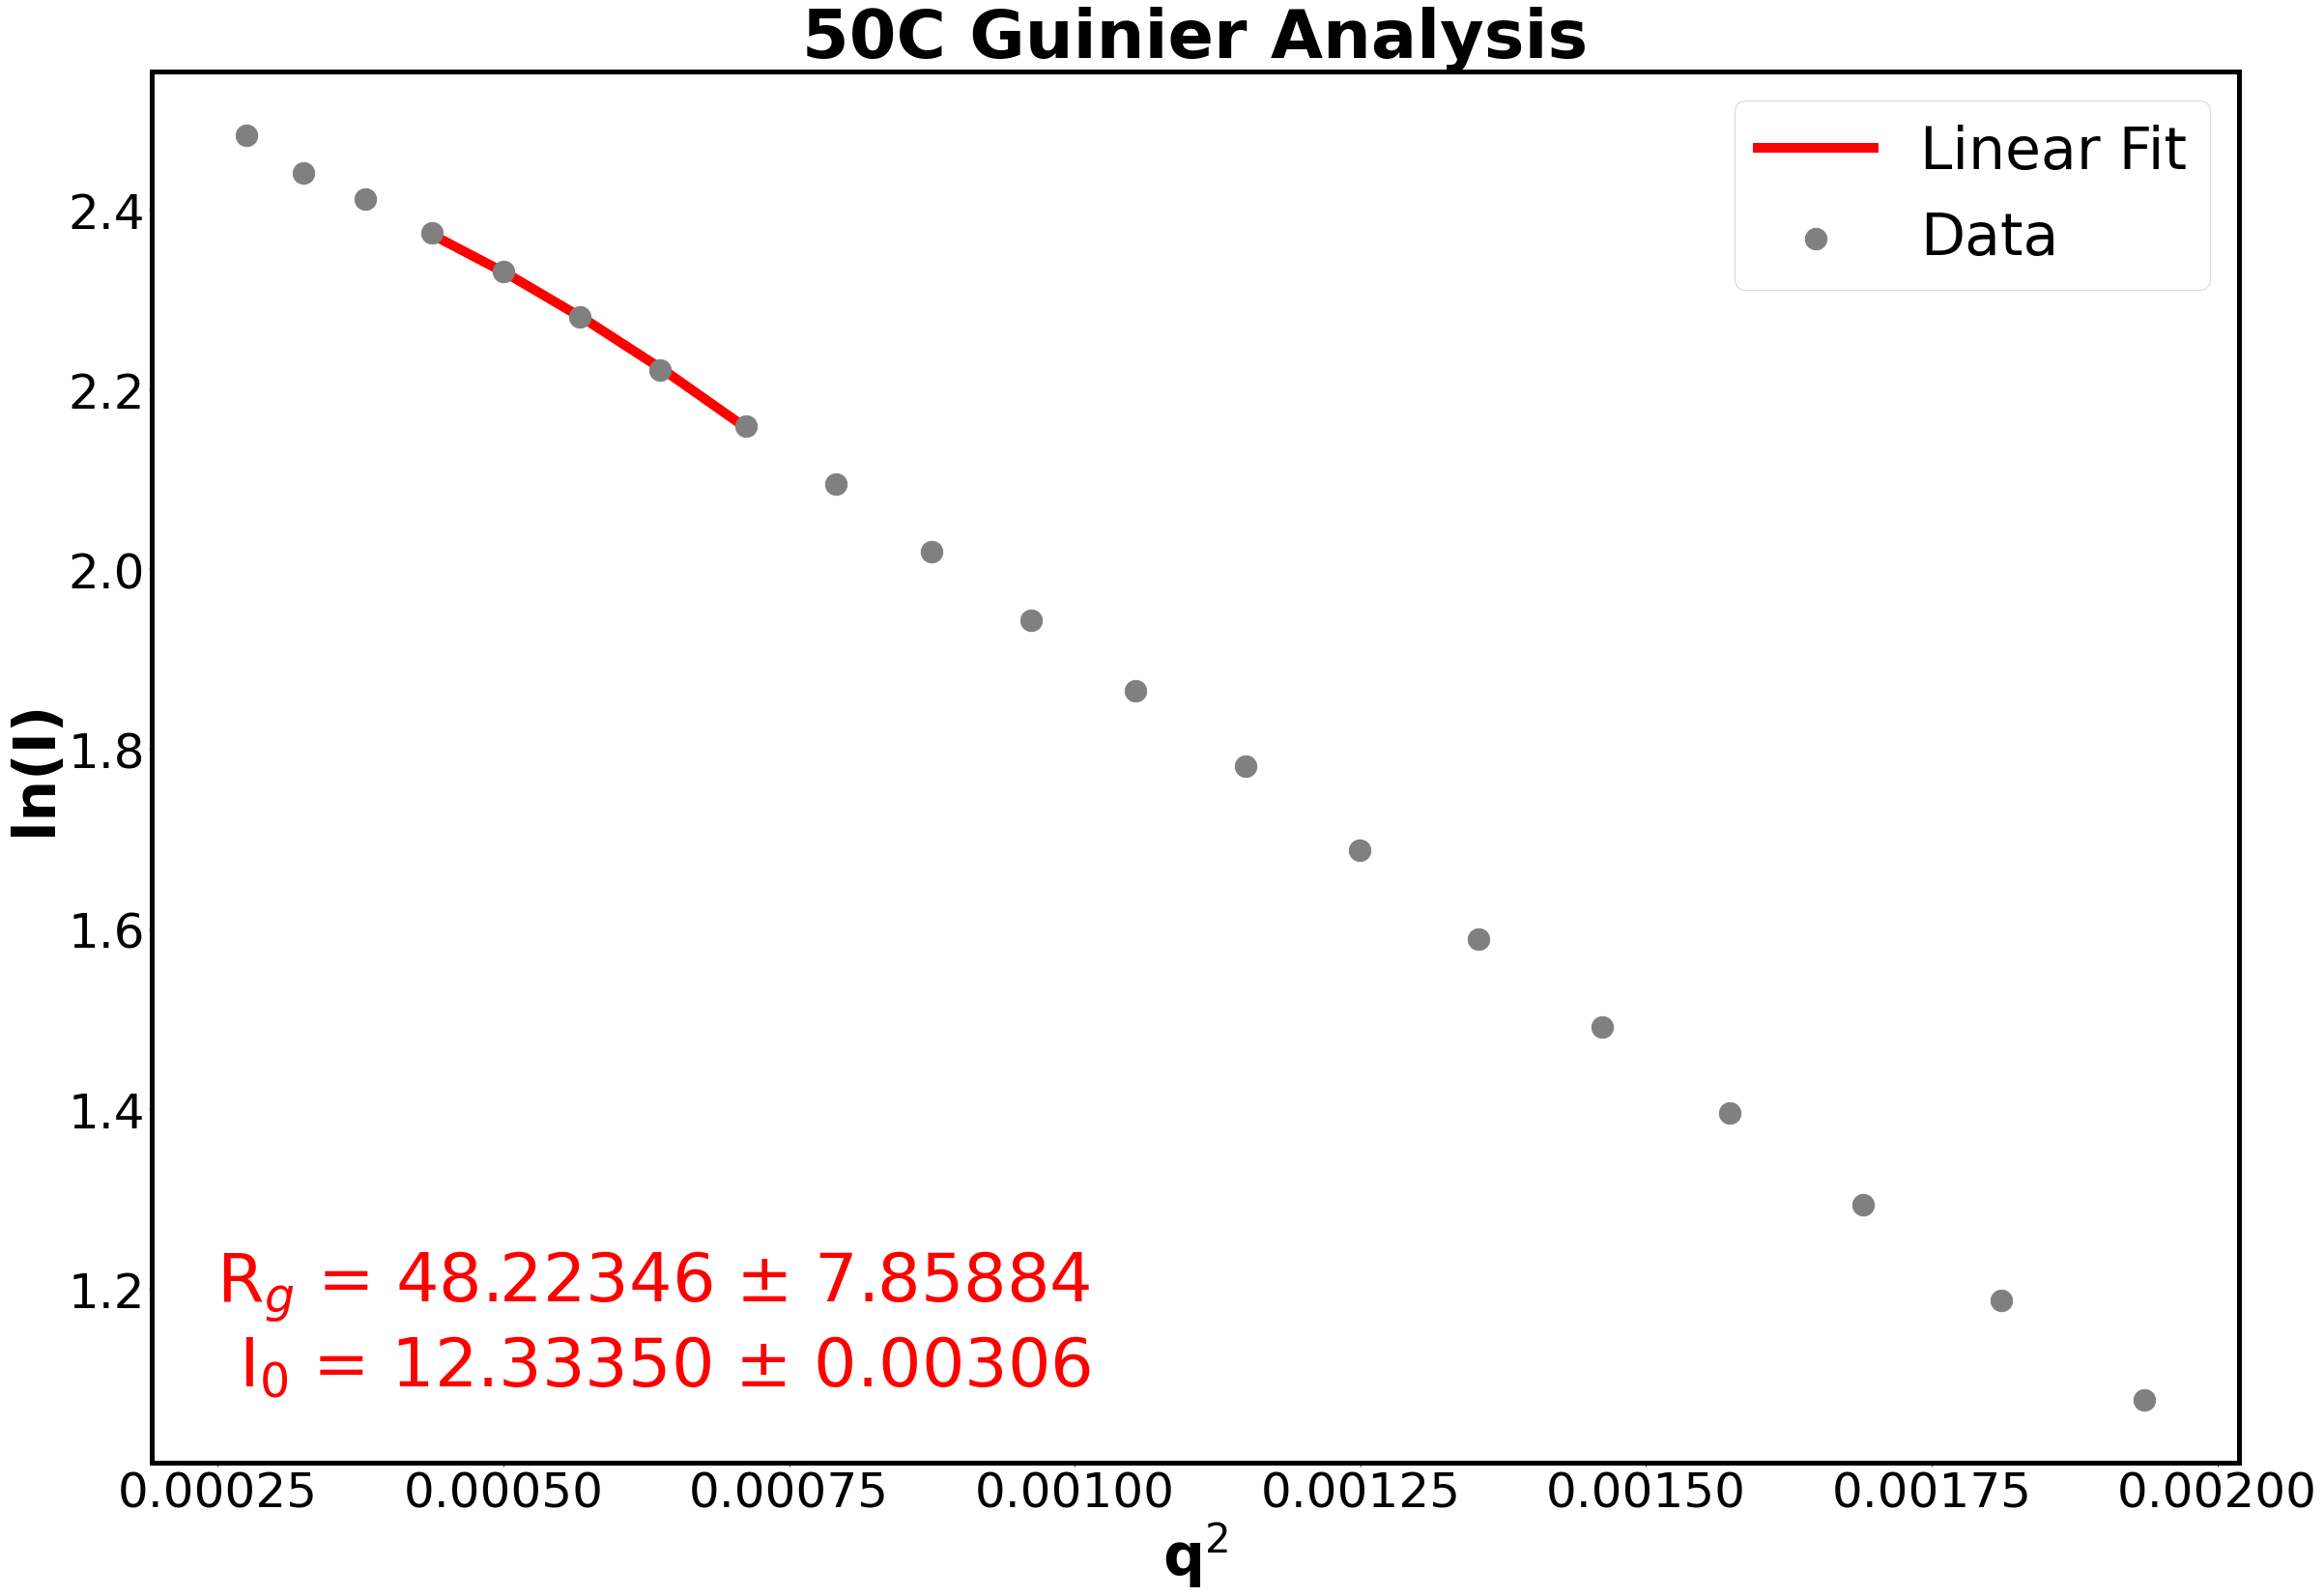

In [2]:
Rg, Rg_error_scaled, I_0, I_0_error_scaled, model = guinier_analysis(file='../../../TR_T-jump_SAXS_July2022/ANALYSIS/PROTEIN/STATIC/AVERAGE/50C_avg.csv', 
                                                                     label='50C', delim=',', mask=0, qmin=0.02, qmax=0.027, 
                                                                     outdir='./OUTPUT/GUINIER/')

# Step 3: Check for Systematic Error

## 3.1: Overview
Aggregation, radiation, interparticle interactions, as well as beam drift during the experiment can lead to the accumulation of small errors during the course of data collection. To check the data for the presence of such errors the `sys_err()` function takes an input file list, bins the files, calculates the average of each bin, and compares the average of the bins to check for systemic errors in data collection. The function will automatically remove pre-determined outlier files, which should be previoulsy determined with the `svd_outliers` and/or `iterative_chi` functions. For help with these functions see Tutorial 2. This function is intended to be used on scattering or difference curve sets, with each scattering curve image imported into the file list. The funtion will plot the mean of each bin, save the plot, and return the cleaned flist, bins, and the mean of each bin. Bin sets determined as outliers based on z-scores are reported by the function.

## 3.2: Input Parameters
The `flist` and `outlier_files` parameters are required input and indicate the file list containing the SAXS scattering.difference curves to check and the file containing the outliers for this data set. The `threshold` parameter indicates the z-score value to use to as a threshold for determining outliers and s optional with a default value of 2.5 standard deviations. The `delim` parameter indicates the type of the delimitter used in the data files, with the default value set to a space. The `mask` parameter indicates how many rows to skip while importing data files. Data is loaded as numpy arrays so any rows containing headers, metadata, or rows with masked data can be skipped with this option. `qmin` and `qmax` indicates the q range to use for showing plot insets. If neither `qmin` nor `qmax` are set, then no plot insets will be created. The `fslice` parameter indicates how to slice the files names to get the image number, with the default set to use the entire file name. `bin_size` is an integer indicating the number of images to include in each bin, with the default value set to 10. The `x`, `y`, and `title` parameters are strings that indicate the labels to use for the x-axis, y-axis, and plot title, respectively. The defualt labels are set to "scattering vector (qÅ-1)", "scattering intensity", and "Scattering Intensity" for `x`, `y`, and `title`, respectively. `save` is a boolean indicating if data should be saved or not, with the default set to save. `save_dir` is a string that indicates the directory to store output data in when `save=True`, with the default set to the current working directory. Similarly, `save_name` indicates the name of the output files when `save=True` with the default set to 'sys_err_qr.png'.


## 3.3: Returned Values
`sys_err` returns a list containg the files with the outliers removed, another list containing the bins used for the analysis, and a lit of the calculated means for each bin. 

## 3.4: Example 1

### 3.4.1: Make a file list
The `sys_err()` function takes a list of files as input, so the first step is to create a file list for the a set of SAXS scattering/difference curves. 

In [8]:
files = make_flist(directory='../../../TR_T-jump_SAXS_July2022/protein_20hz_set01/processedb/',
                  prefix='protein_20hz_set01_1ms_', suffix='_Q.chi')

Getting files:   0%|          | 0/12016 [00:00<?, ?it/s]

Done loading 250 files!


#### 3.4.2: Load outlier file list
The `sys_err()` function also takes a list of outliers files that have been previously determined. We also need to load this list before proceeding with the systemiatic error analysis. Remeber that for T-Jump scattering curves the outliers list for both "laser off" and "laser on" outliers needs to be loaded. 

In [9]:
on_outliers1 = './OUTPUT/OUTLIERS/1ms_svd_outliers1.csv'
on_outliers2 = './OUTPUT/OUTLIERS/1ms_svd_outliers2.csv'

off_outliers1 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers1.csv'
off_outliers2 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers2.csv'

on_outliers = on_outliers1 + on_outliers2
off_outliers = off_outliers1 + off_outliers2

Number of files loaded: 250
Number of outliers to remove: 2
WARNING! Number of files remaining after outliers removed: 250 does not match the number expected based on the size of input file and outlier lists


Loading curves:   0%|          | 0/250 [00:00<?, ?it/s]

Done loading 250 curves!
Outlier bin(s) found:  [ 0  0  0 ... 24 24 24]
Directory already exists!


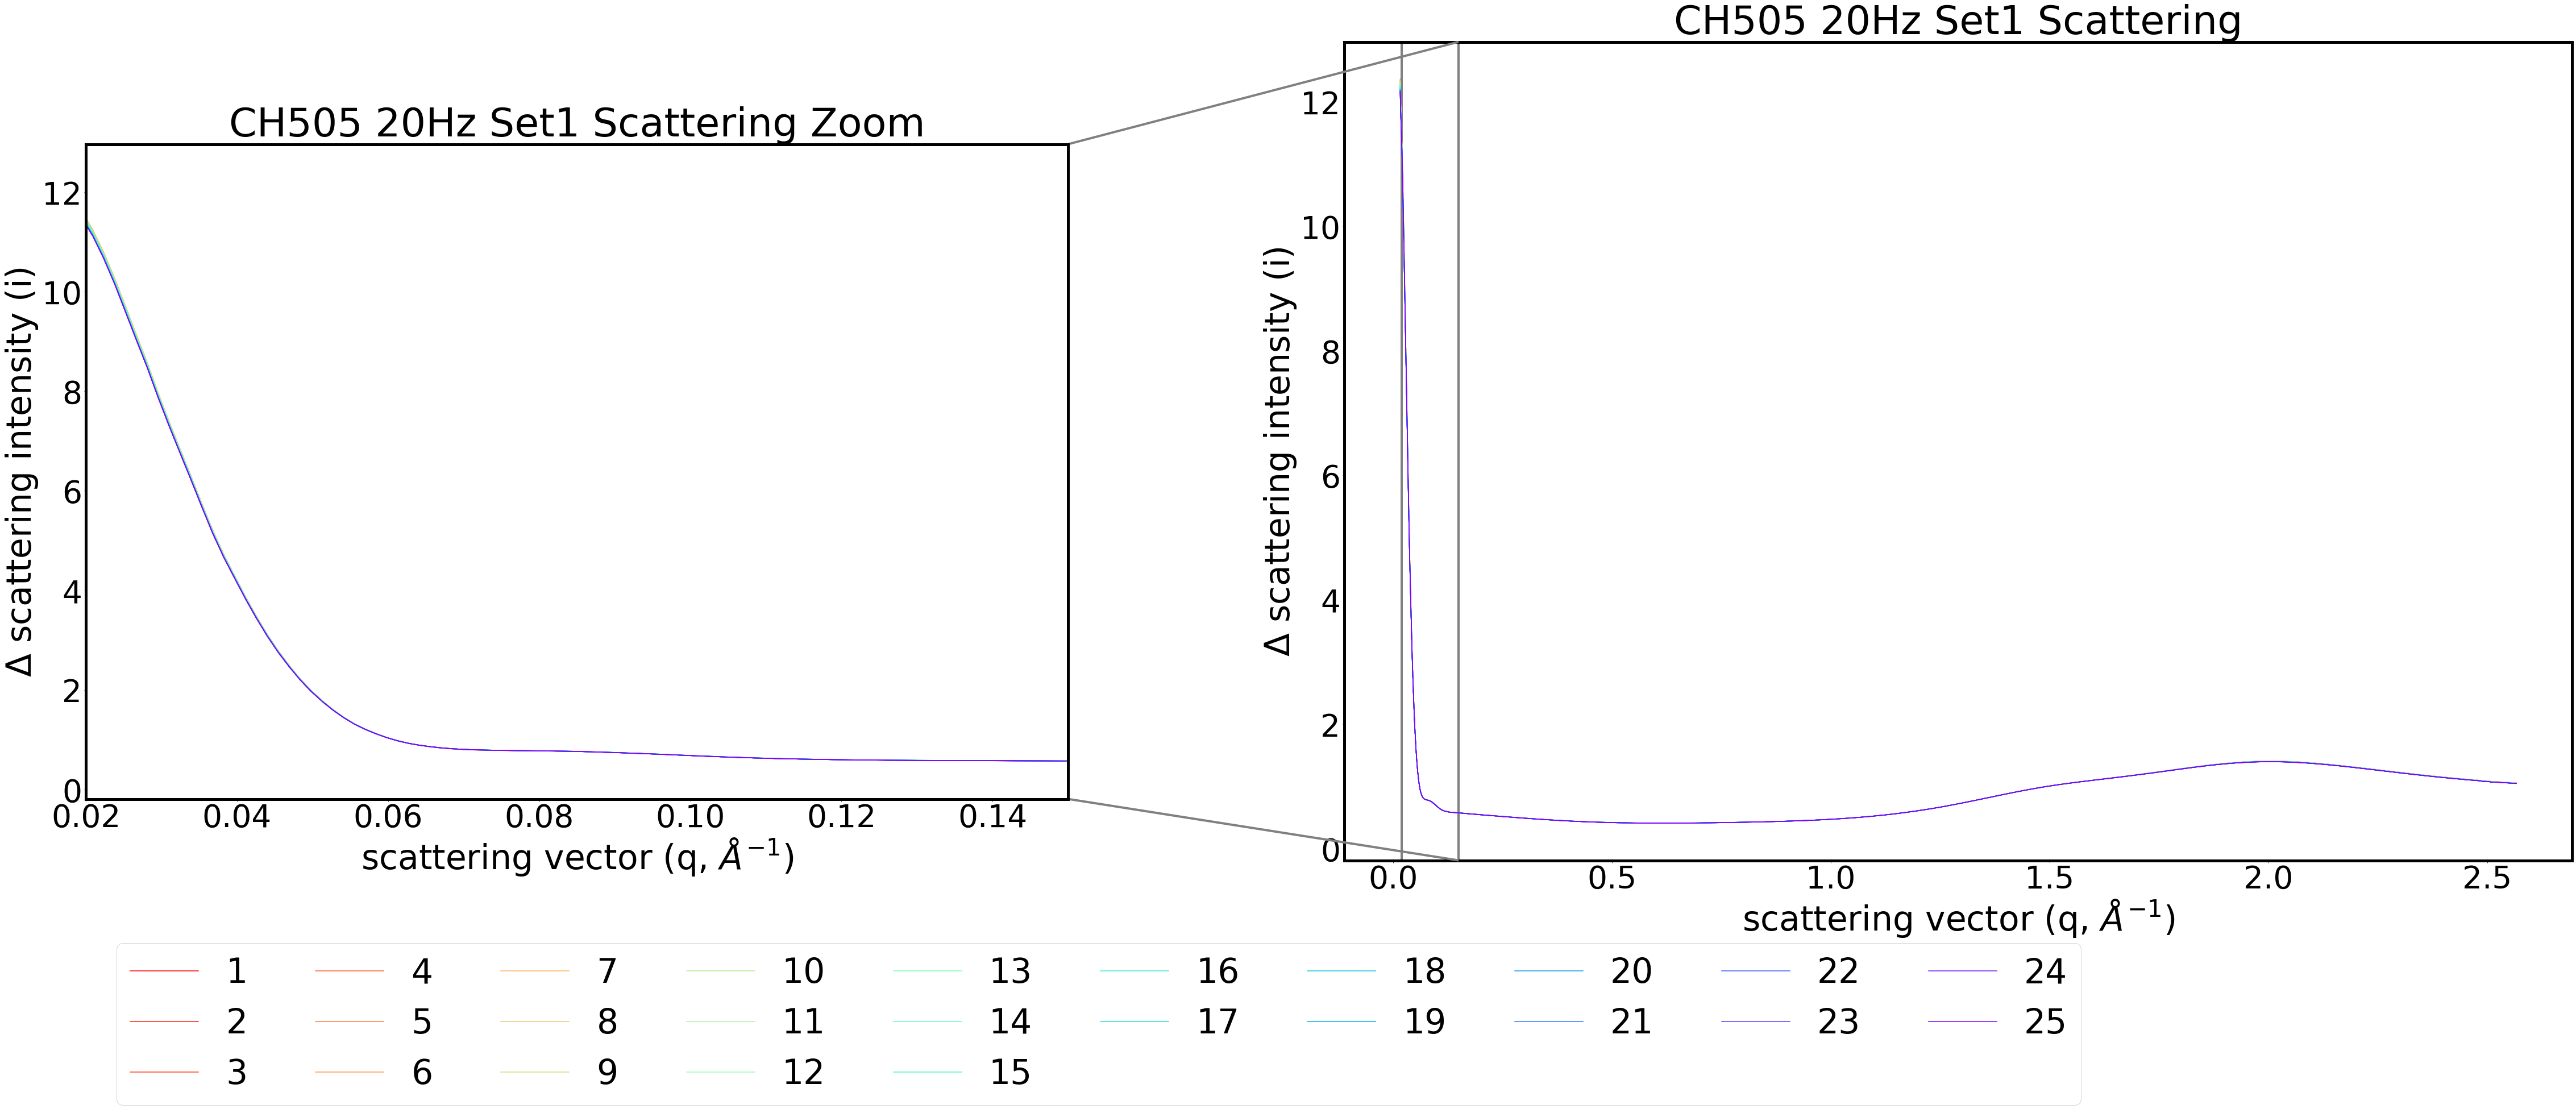

In [10]:
files, bins, means = sys_err(flist=files, outlier_files=[on_outliers, off_outliers], threshold=2.5, delim=' ',
                             mask=0, err=False, qmin=0.02, qmax=0.15, fslice=[-9,-6], bin_size=10, 
                             x='scattering vector (q, $\\AA^{-1}$)', y='$\\Delta$ scattering intensity (i)',
                             title='CH505 20Hz Set1 Scattering', save=True, 
                             save_dir='./OUTPUT/SYS_ERR/', save_name='ch505_trimeronly_20hz_set1')

As you can see in the plots above, the average for each bin overlay nicely for the scattering curves and there appears to be no systematic errors present. Before proceeding, it is also a good idea to check the difference curves as well. 

Getting files:   0%|          | 0/251 [00:00<?, ?it/s]

Done loading 250 files!
Number of files loaded: 250
Number of outliers to remove: 3
WARNING! Number of files remaining after outliers removed: 250 does not match the number expected based on the size of input file and outlier lists


Loading curves:   0%|          | 0/250 [00:00<?, ?it/s]

Done loading 250 curves!
No Outliers!
Directory already exists!


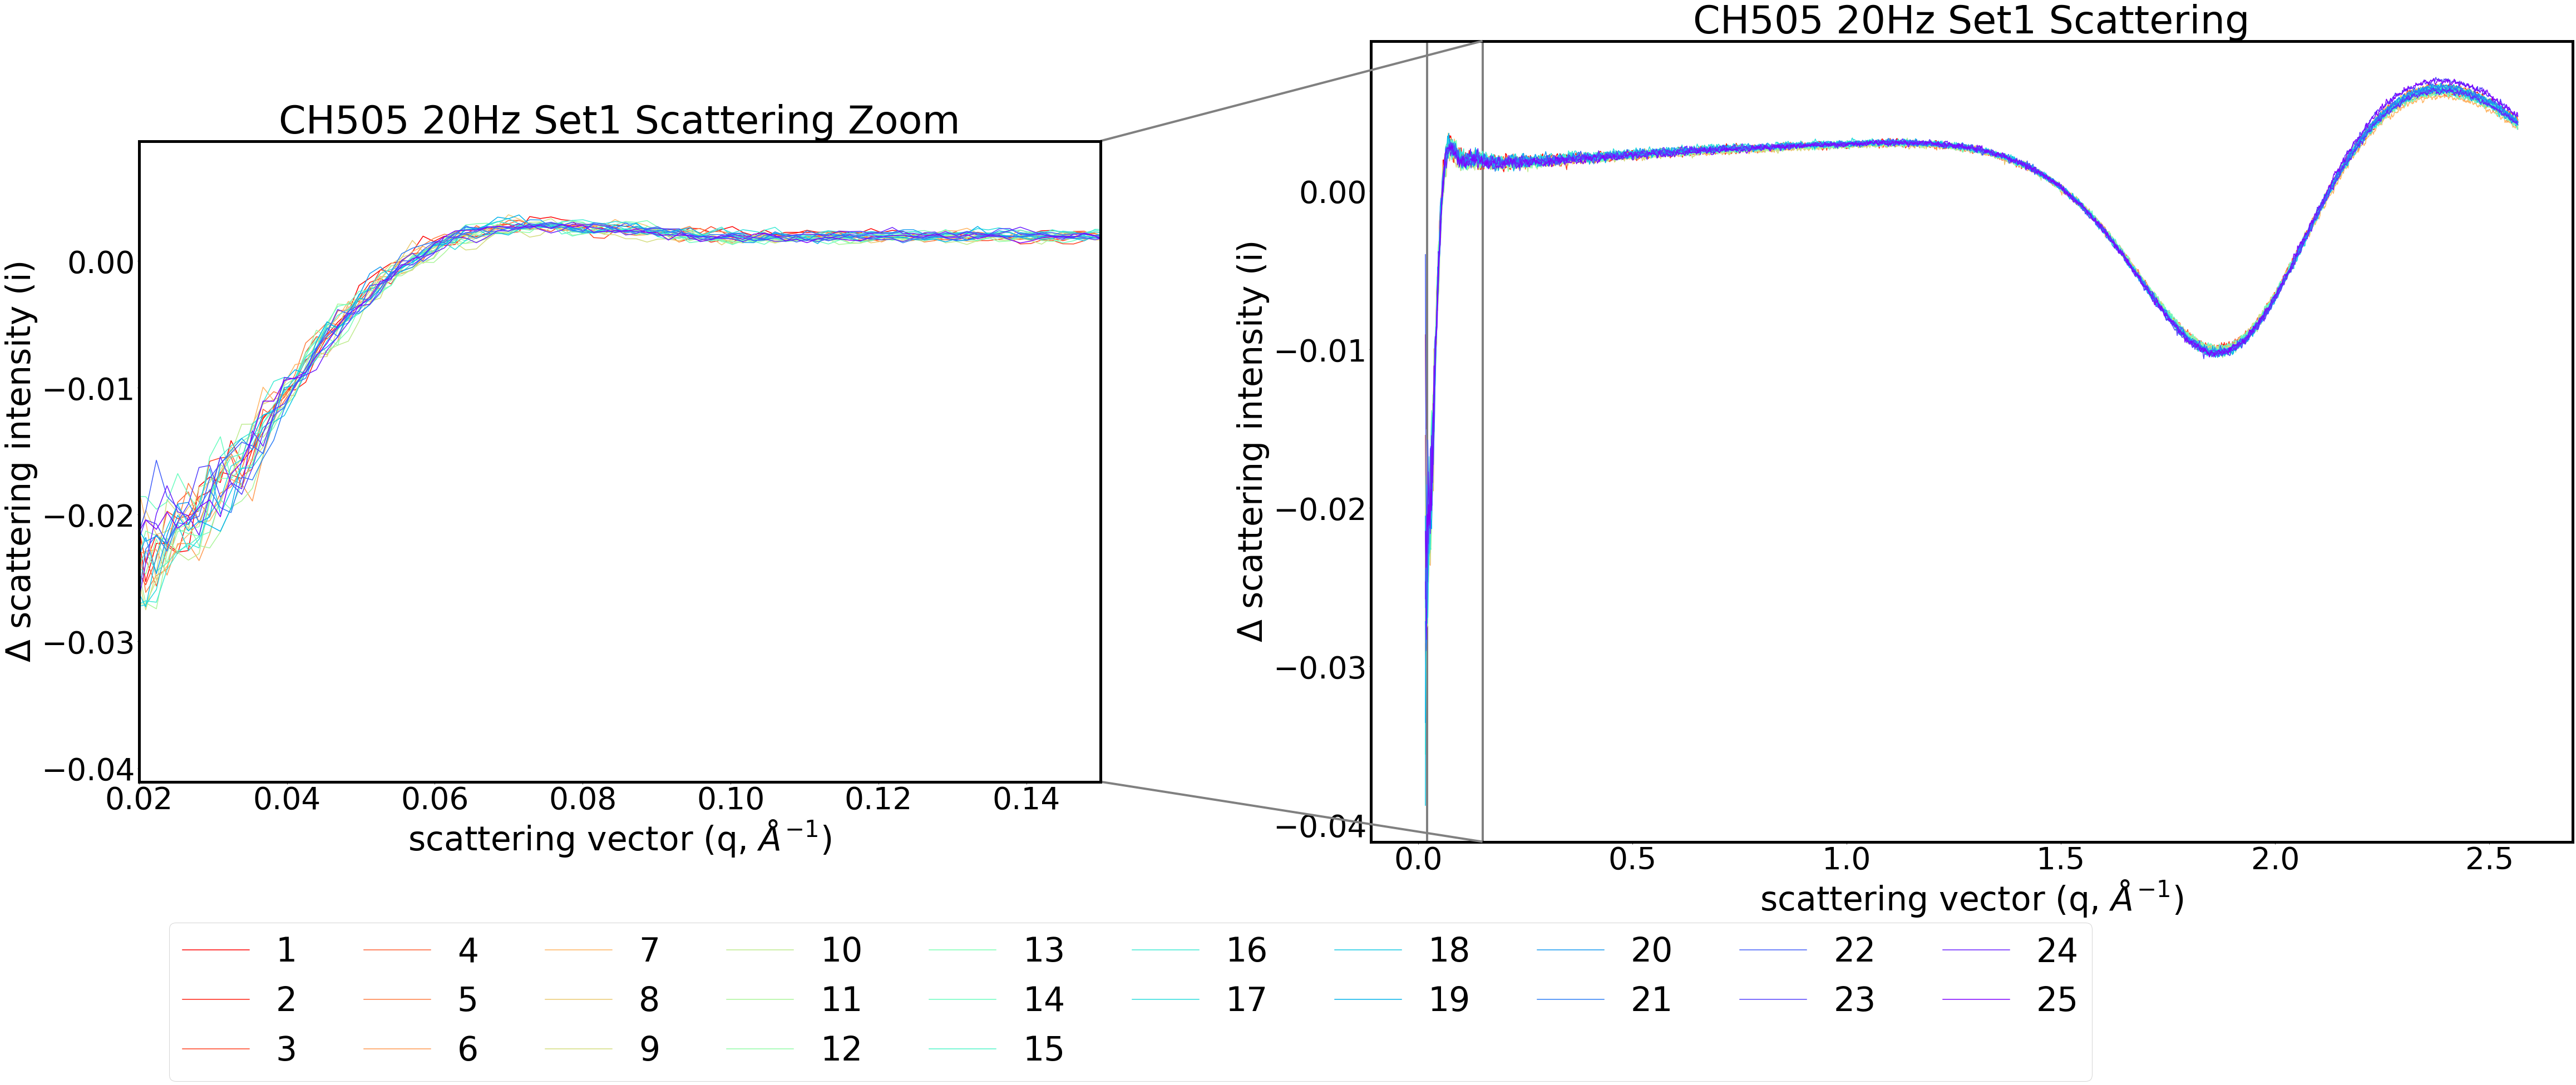

In [12]:
# get file list
files = make_flist(directory='./OUTPUT/DIFF_CURVES/',
                  prefix='diff__set01_1ms_', suffix='_Q.chi')

# Get outlier files
on_outliers1 = './OUTPUT/OUTLIERS/1ms_svd_outliers1.csv'
on_outliers2 = './OUTPUT/OUTLIERS/1ms_svd_outliers2.csv'

off_outliers1 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers1.csv'
off_outliers2 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers2.csv'

chi_outliers ='./OUTPUT/OUTLIERS/1ms_chi_outliers.csv'

on_outliers = on_outliers1 + on_outliers2
off_outliers = off_outliers1 + off_outliers2

# systematic error analysis on difference curves
files, bins, means = sys_err(flist=files, outlier_files=[on_outliers, off_outliers, chi_outliers], 
                             threshold=2.5, delim=',',mask=0, err=False, qmin=0.02, qmax=0.15, 
                             fslice=[-9,-6], bin_size=10, x='scattering vector (q, $\\AA^{-1}$)', 
                             y='$\\Delta$ scattering intensity (i)',
                             title='CH505 20Hz Set1 Scattering', save=True, 
                             save_dir='./OUTPUT/SYS_ERR/', save_name='ch505_trimeronly_20hz_set1_diff_')

Again, we see that the average of each bin for the difference curve aligns well, showing that there is no notable systematic error in the data set.

# Step 4: Kratky Analysis

## 3.1: Overview
Kratky plots assess the globular state of a protein from SAXS scattering curves. In the `tr_tjump_saxs_analysis` package the `kratky_plot` function will perform a kratky analysis and plot the results. 

## 3.2: Input Parameters
The only required parameter is `files`, which is a list contining files, with full path, containing SAXS curves to make Kratky plots for. Assumes that the input files contain two columns with the scattering vector (q) and the scattering intensity (i). If err=True, the the experimental error will also be loaded as long as the input data file contains a third column with the experimental error. 

There are also several optional parameters. `delim` is a stri indicating the delimitter used in input files. Default valaue is comma (','). The `mask` parameter is an int indicating the number of rows to skip when loading files. Default values is 0. This is useful for skipping rows with NaN or masked values. `err` is a bool indicating if there is the column containing experimental error. If set to False, then no errors will be loaded. Default value is False. The `labels` parameter is a list containing labels to use for plot. If set to None, then output plot will have no labels. Default value is None. `qmin` and `qmax` are floats indicating the minimum and maximum, respectively, Q value for a zoomed in inset plot. If set to None, then the qmin will be determined from the minimum q value in the input set of curves. If both qmin and qmax are set to None, then the inset will include the entire Q range. If qmin, qmax, imin, and imax are all set to None, then no inset plot will be made. Default value is None. The `imin` and `imax` parameters are floats indicating, respectively, the minimum and maximum I values for a zoomed in inset plot. If set to None, then the imin will be determined from the minimum I value in the input set of curves. If both imin and imax are set to None, then the inset will include the entire I range. If qmin, qmax, imin, and imax are all set to None, then no inset plot will be made. Default value is None. `x` and `y` are a str labels for the x and y axes of plots. Default value is 'scattering vector'. The `title` paraemter is a str for the title for plot. Default value is 'SAXS Scattering Curve'. `save` is a bool indicating if the plot should be saved to file. If set to False then the plot will not be saved. Default value is False. `save_dir` is a str denoting the directory to store output files in. If the directory does not exist, then it will be made. The default value is None. working directory. `save_name` is the str for the file name to save plot to. Plot only will be saved if save=True. 


## 3.3: Returned Values
`kratky`, which is a Numpy array containing Kratky values (without q).

## Example 1: Basic Usage

In [17]:
all_outliers

'./OUTPUT/OUTLIERS/1ms_svd_outliers1.csv./OUTPUT/OUTLIERS/1ms_svd_outliers2.csv./OUTPUT/OUTLIERS/1ms_-5us_svd_outliers1.csv./OUTPUT/OUTLIERS/1ms_-5us_svd_outliers2.csv'

In [16]:
# make file list
files = make_flist(directory='../../../TR_T-jump_SAXS_July2022/protein_20hz_set01/processedb/',
                  prefix='protein_20hz_set01_1ms_', suffix='_Q.chi')

# remove outliers
on_outliers1 = './OUTPUT/OUTLIERS/1ms_svd_outliers1.csv'
on_outliers2 = './OUTPUT/OUTLIERS/1ms_svd_outliers2.csv'

off_outliers1 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers1.csv'
off_outliers2 = './OUTPUT/OUTLIERS/1ms_-5us_svd_outliers2.csv'

on_outliers = on_outliers1 + on_outliers2
off_outliers = off_outliers1 + off_outliers2
all_outliers = on_outliers + off_outliers

cleaned, olist = remove_outliers(flist=files, olist=all_outliers, fslice=[-9,-6])


# kratky analysis
kratky_plot(files=cleaned, delim=',', mask=0, err=True, labels='protein_20hz_set01_1ms', qmin=0.0, qmax=0.1, 
            imin=0, imax=0.0075, x='Scattering Vector, q (Å$^{-1}$)', y='q$^{2}$I', 
            title='SAXS Scattering Curve', 
            save=True, save_dir='./OUTPUT/KRATKY/', 
            save_name='protein_20hz_set01_1ms')

Getting files:   0%|          | 0/12016 [00:00<?, ?it/s]

Done loading 250 files!


TypeError: [1;91mTypeError: Oops! olist must be list type. Try again...[1;91m

# Step 5: Looping Ove Multiple Time Delays or Data Sets

As described in previous tutorials, all the functions in the `saxs_qc` module presented here can be included inside a loop to automate analysis over multiple time delays or data sets at once. Note that in these tutorials `for` loops are used. However, `for` loops are not the most efficient method for iterating in Python and more efficient implementations exist. 